<a href="https://www.kaggle.com/sourabhmiglani/gan-final?scriptVersionId=83844722" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

### Import Necessary Library

In [25]:
import numpy as np
import tensorflow as tf
import keras
import cv2
from keras.layers import MaxPooling2D, Conv2D, UpSampling2D, Input, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.models import Model
from keras.preprocessing.image import img_to_array
import os
from tqdm import tqdm
import re
import time
import matplotlib.pyplot as plt

In [26]:
# to get the image's path in proper sorted order
def get_sorted_path(data):
    new_data = [int(i.split('.')[0]) for i in data]
    new_data.sort()
    converted_list = [str(i)+'.jpg' for i in new_data]
    return converted_list

In [27]:
# defining image size
IMAGE_SIZE = 128
color_img = []
path = '../input/hghgghghgh/Human_faces/color'
files = os.listdir(path)
files = get_sorted_path(files)
from sklearn.model_selection import train_test_split
for i in tqdm(files):
    img = cv2.imread(os.path.join(path, i))
    # open cv reads images in BGR format so we have to convert it to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # resizing image
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    # applying normalization
    img = img.astype('float32') / 255.0
    # appends images in color_img list
    color_img.append(img_to_array(img))
    
gray_img = []
path = '../input/hghgghghgh/Human_faces/gray'
files = os.listdir(path)
files = get_sorted_path(files)

for i in tqdm(files):
    img = cv2.imread(os.path.join(path, i))
    # resizing image
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    img = img.astype('float32') / 255.0
    gray_img.append(img_to_array(img))

100%|██████████| 5749/5749 [00:13<00:00, 419.22it/s]


In [28]:
# defining function to plot images pair
def plot_image(color, grayscale):
    plt.figure(figsize = (15,15))
    plt.subplot(1,3,1)
    plt.title('Color Image', color = 'red', fontsize = 20)
    plt.imshow(color)
    plt.subplot(1,3,2)
    plt.title('Grayscale Image', color = 'black', fontsize = 20)
    plt.imshow(grayscale)
    plt.show()

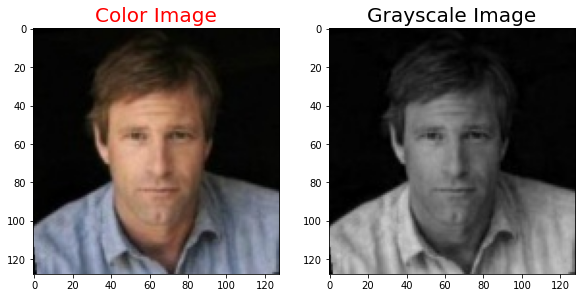

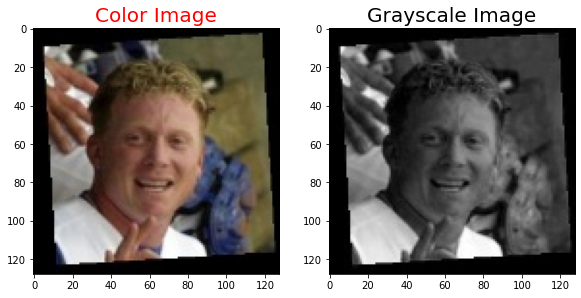

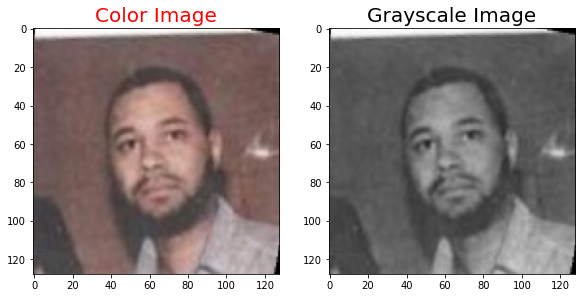

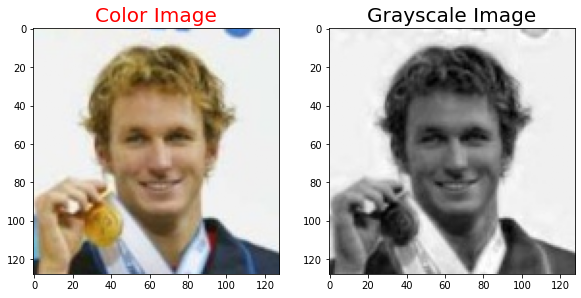

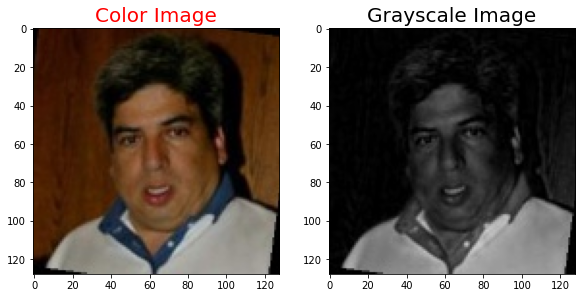

In [29]:
for i in range(5):
    plot_image(color_img[i], gray_img[i])

### Creating Training Dataset and Testing Dataset

In [30]:
#There are total 5720 images I have splited the dataset into 70:30 for training and testing the model

train_gray_image = gray_img[:4024]
train_color_image = color_img[:4024]

test_gray_image = gray_img[4024:]
test_color_image = color_img[4024:]

# reshaping
train_g = np.reshape(train_gray_image,(-1,IMAGE_SIZE, IMAGE_SIZE, 3))
train_c = np.reshape(train_color_image,(-1,IMAGE_SIZE, IMAGE_SIZE, 3))
print('Train color image shape : {}'.format(train_c.shape))

test_g = np.reshape(test_gray_image,(-1,IMAGE_SIZE, IMAGE_SIZE, 3))
test_c = np.reshape(test_color_image,(-1,IMAGE_SIZE, IMAGE_SIZE, 3))
print('Test color image shape : {}'.format(test_c.shape))

Train color image shape : (4024, 128, 128, 3)
Test color image shape : (1725, 128, 128, 3)


### Defining our Model

In [31]:
from keras import layers


# Down Sampling Layer Function
def down(filters, kernal_size, apply_batch_normalization = True):
    downsample = Sequential()
    downsample.add(Conv2D(filters, kernal_size, padding = 'same', strides = 2))
    if apply_batch_normalization:
        downsample.add(keras.layers.BatchNormalization())
    downsample.add(keras.layers.LeakyReLU())
    return downsample


# Up Sampling Layer Function
def up(filters, kernal_size, dropout = False):
    upsample = Sequential()
    upsample.add(layers.Conv2DTranspose(filters, kernal_size, padding = 'same', strides = 2))
    if dropout:
        upsample.dropout(0.2)
    upsample.add(keras.layers.LeakyReLU())
    return upsample

In [32]:
def model():
    
    # input layer
    inputs = Input(shape = (128, 128, 3))
    
    # Downsampling
    d1 = down(64, (3,3), False)(inputs)  # 64
    d2 = down(128, (3,3), True)(d1)     # 32
    d3 = down(128, (3,3), True)(d2)      # 16
    d4 = down(256, (3,3), True)(d3)      # 8
    d5 = down(512, (3,3), True)(d4)      # 4
    
    # Bottle Neck
    d6 = down(512, (3,3), True)(d5) # 2
    
    # Upsampling
    u1 = up(512, (3,3), False)(d6)  # 4
    u1 = layers.concatenate([u1,d5])
    u2 = up(256, (3,3), False)(u1)  # 8
    u2 = layers.concatenate([u2,d4]) 
    u3 = up(128, (3,3), False)(u2)  # 16
    u3 = layers.concatenate([u3,d3])
    u4 = up(128, (3,3), False)(u3)  #  32
    u4 = layers.concatenate([u4,d2])
    u5 = up(64, (3,3), False)(u4)   # 64
    u5 = layers.concatenate([u5,d1])
    
    # output layer
    u6 = up(3, (3,3), False)(u5)
    u6 = layers.concatenate([u6,inputs])
    output = Conv2D(3, (2,2), strides = 1, padding = 'same')(u6)
    
    return Model(inputs = inputs, outputs = output)

In [33]:
model = model()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
sequential_12 (Sequential)      (None, 64, 64, 64)   1792        input_2[0][0]                    
__________________________________________________________________________________________________
sequential_13 (Sequential)      (None, 32, 32, 128)  74368       sequential_12[0][0]              
__________________________________________________________________________________________________
sequential_14 (Sequential)      (None, 16, 16, 128)  148096      sequential_13[0][0]              
____________________________________________________________________________________________

In [34]:
model.compile(optimizer = Adam(0.001), loss = 'mean_absolute_error', metrics = ['acc'])

In [35]:
start_time = time.time()
history = model.fit(train_g, train_c, epochs = 10, batch_size = 64, verbose = 1)
end_time = time.time()

Epoch 1/10
63/63 [==============================] - 7s 82ms/step - loss: 0.1407 - acc: 0.4630
Epoch 2/10
63/63 [==============================] - 5s 83ms/step - loss: 0.0723 - acc: 0.6017
Epoch 3/10
63/63 [==============================] - 5s 82ms/step - loss: 0.0663 - acc: 0.6148
Epoch 4/10
63/63 [==============================] - 5s 83ms/step - loss: 0.0633 - acc: 0.6261
Epoch 5/10
63/63 [==============================] - 5s 83ms/step - loss: 0.0607 - acc: 0.6348
Epoch 6/10
63/63 [==============================] - 5s 82ms/step - loss: 0.0590 - acc: 0.6407
Epoch 7/10
63/63 [==============================] - 5s 82ms/step - loss: 0.0569 - acc: 0.6513
Epoch 8/10
63/63 [==============================] - 5s 83ms/step - loss: 0.0551 - acc: 0.6585
Epoch 9/10
63/63 [==============================] - 5s 82ms/step - loss: 0.0530 - acc: 0.6716
Epoch 10/10
63/63 [==============================] - 5s 83ms/step - loss: 0.0512 - acc: 0.6790


In [ ]:
def convert(seconds):
    seconds = seconds % (24 * 3600)
    hour = seconds // 3600
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60
      
    return "%d:%02d:%02d" % (hour, minutes, seconds)

In [ ]:
total_time_taken = convert(end_time - start_time)
print('Model took {} (HH:MM:SS) time to train'.format(total_time_taken))

In [ ]:
model.save('Autoencoder_200e.h5')

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.plot(np.arange(200)+1, history.history['acc'], color = 'r')
plt.title('Model Accuracy', color = 'red', fontsize = 15)
plt.ylabel('< - - - - - Accuracy - - - - - >', fontsize = 15, color = 'red')
plt.xlabel('< - - - - - Epoch - - - - - >', fontsize = 15, color = 'red')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig('model accuracy.png')
plt.grid()

plt.subplot(1,2,2)
plt.plot(np.arange(200)+1, history.history['loss'], color= 'purple')
plt.title('Model Loss', color = 'purple', fontsize = 15)
plt.ylabel('< - - - - - Loss - - - - - >', fontsize = 15, color = 'purple')
plt.xlabel('< - - - - - Epoch - - - - - >', fontsize = 15, color = 'purple')
plt.savefig('model loss.png')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid()


plt.show()

In [ ]:
model.evaluate(test_g, test_c)

### After 50 epochs, We have got 74% accuracy on training dataset and 55% accuracy on testing dataset

In [ ]:
def plot_images(color,grayscale,predicted):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('Ground Truth', color = 'green', fontsize = 20)
    plt.imshow(color)
    plt.subplot(1,3,2)
    plt.title('Grayscaled Image ', color = 'black', fontsize = 20)
    plt.imshow(grayscale)
    plt.subplot(1,3,3)
    plt.title('Colorized Image', color = 'Red', fontsize = 20)
    plt.imshow(predicted)
   
    plt.show()

## Result on testing data

In [ ]:
for i in range(80,85):
    predicted = np.clip(model.predict(test_g[i].reshape(1,IMAGE_SIZE, IMAGE_SIZE,3)),0.0,1.0).reshape(IMAGE_SIZE, IMAGE_SIZE,3)
    plot_images(test_c[i],test_g[i],predicted)

In [ ]:
for i in range(50,55):
    predicted = np.clip(model.predict(test_g[i].reshape(1,IMAGE_SIZE, IMAGE_SIZE,3)),0.0,1.0).reshape(IMAGE_SIZE, IMAGE_SIZE,3)
    plot_images(test_c[i],test_g[i],predicted)

## Result on training data

In [ ]:
for i in range(80,85):
    predicted = np.clip(model.predict(train_g[i].reshape(1,IMAGE_SIZE, IMAGE_SIZE,3)),0.0,1.0).reshape(IMAGE_SIZE, IMAGE_SIZE,3)
    plot_images(train_c[i],train_g[i],predicted)

In [ ]:
for i in range(100,105):
    predicted = np.clip(model.predict(train_g[i].reshape(1,IMAGE_SIZE, IMAGE_SIZE,3)),0.0,1.0).reshape(IMAGE_SIZE, IMAGE_SIZE,3)
    plot_images(train_c[i],train_g[i],predicted)

## Model Evaluation on different value of e

In [ ]:
# Evaluate funtion which will return Accuracy and MAE(Mean Absolute Error) of the model
def evaluate(x,y,e,model):
    y_predicted = model.predict(x)
    MAE = np.mean(np.absolute(y_predicted-y))
    diff = np.absolute(y_predicted-y)
    count = diff <= e
    accurate_value_count = count.sum()
    total_values = x.shape[0]*IMAGE_SIZE*IMAGE_SIZE*3
    accuracy = (accurate_value_count/total_values)*100
    return accuracy,MAE

In [ ]:
testing_dataset_eval = []
training_dataset_eval = []
e = [0.01, 0.03, 0.05, 0.1]

for i in e:
    testing_dataset_eval.append(evaluate(test_g, test_c, i, model))
    print(i , " Done")
print("Testing Part Done!!! ")    
for i in e:
    training_dataset_eval.append(evaluate(train_g, train_c, i, model))
    print(i ," Done")
print("All Done!!!")

In [ ]:
for i in range(4):
    print('e = {}'.format(e[i]))
    print()
    print('On Training Dataset : ', end="")
    print('Accuracy = {} '.format(round(training_dataset_eval[i][0]),4), end='')
    print('and MAE = ', round(training_dataset_eval[i][1],4))
    print('On Testing Dataset : ', end="")
    print('Accuracy = {} '.format(round(testing_dataset_eval[i][0])), end=' ')
    print('and MAE = ', round(testing_dataset_eval[i][1],4))
    print('----------------------------------------------------------------------------------')
    print()

# Model Loading

In [ ]:
# from keras.models import load_model
# model = load_model('Autoencoder.h5')